# Twitter Sentiments Analysis
## Summary
This project aims to analyze the sentiment of tweets related to Apple and Google products using Natural Language Processing (NLP) techniques. The dataset used contains over 9,000 tweets rated by human raters as either positive, negative, or neutral. The goal is to build a model capable of determining the sentiment of a tweet based on its content, which can be used for analyzing public perception of these tech companies.

#### The project involved the following steps:
* Data Preparation:
 Cleaned the data, removed irrelevant content, and vectorized the text using TF-IDF.
* Model Building:
  A baseline Logistic Regression model and a DecisionTreeClassifier were first built for binary classification (positive vs. negative). We then extended them to multiclass classification to include neutral tweets.
* Advanced Models:
  We applied XGBoost on both binary and multiclass classification.
* Model Evaluation:
 The models were evaluated and compared using metrics such as accuracy.
 The best-performing model was the XGBoost for binary classification and DecisionTreeClassifier for the multiclass   classification, which showed high accuracy and balanced precision and recall across all classes. These models provide practical solutions for real-time analysis of tweet sentiments related to Apple and Google products.

* In conclusion, this project highlights the effectiveness of different machine learning models in sentiment analysis tasks, with XGBoost for binary classification and DecisionTreeClassifier for the multiclass classification proving to be the most suitable for our dataset.

## Business Understanding
#### 1. Objective:
The goal is to build an NLP model that rates the sentiment of a Tweet as positive, negative, or neutral, based on its content. This is useful for companies to understand customer opinions, make decisions, and improve products.

#### 2. Target Audience:
The sentiment analysis could help marketers, product managers, and customer service teams understand how users feel about products.

#### 3. Success Criteria:
Success is measured by the accuracy and other classification metrics (Precision, Recall and F1-score) of the model. An acceptable model should classify sentiments effectively

## Data Understanding
* The dataset, sourced from `CrowdFlower` via [data.world](https://data.world/crowdflower/brands-and-product-emotions), contains over 9,000 tweets rated by human annotators as positive, negative, or neutral.
* The dataset comprises tweets collected from Twitter, containing:
1. Tweet Text: The content of the tweets where users express their opinions.
2. Emotion Directed At: The specific product or brand the sentiment is directed towards (e.g., Apple, Google).
3. Type of Emotion: The sentiment type classified into categories such as positive, negative, and neutral

## Importing Relevant Libraries


In [128]:
#Import the neccessary libraries
#Libraries for Loading the dataset and EDA
import pandas as pd
from collections import Counter
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#Libraries for NLP
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
from wordcloud import WordCloud
#Libraries for modeling 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE

from collections import Counter

warnings.filterwarnings('ignore')

In [129]:
#Load the datatset
tweets = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
tweets.head(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [130]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [131]:
tweets.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [132]:
tweets.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [133]:
#drop missing data in tweet_text
tweets.dropna(subset =['tweet_text'], inplace = True)

In [134]:
#handle the missing data
tweets['emotion_in_tweet_is_directed_at'].fillna('Unknown', inplace = True)

In [135]:
#check if values are filled
tweets.isnull().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [136]:
#Check the groupings of the dataset for is_there_an_emotion_directed_at_a_brand_or_product
tweets.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [137]:
#reduce the options for is_there_an_emotion_directed_at_a_brand_or_product
tweets['is_there_an_emotion_directed_at_a_brand_or_product'] = tweets['is_there_an_emotion_directed_at_a_brand_or_product'].replace(["No emotion toward brand or product","I can't tell"], 'Neutral')
tweets.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Neutral             5544
Positive emotion    2978
Negative emotion     570
Name: count, dtype: int64

In [138]:
#Verify they have been reduced
tweets.head(15)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Unknown,Neutral
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


In [139]:
#Let's look at the value_counts for the emotion_is_directed_at column
tweets.emotion_in_tweet_is_directed_at.value_counts()

emotion_in_tweet_is_directed_at
Unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: count, dtype: int64

In [140]:
#Remove the columns where the emotion_in_tweet_is_directed_at is 'Unknown'
tweets = tweets[tweets['emotion_in_tweet_is_directed_at']!= 'Unknown']

In [141]:
#Verify the 'unknown'values have been removed
tweets.head(25)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion
11,Find &amp; Start Impromptu Parties at #SXSW Wi...,Android App,Positive emotion


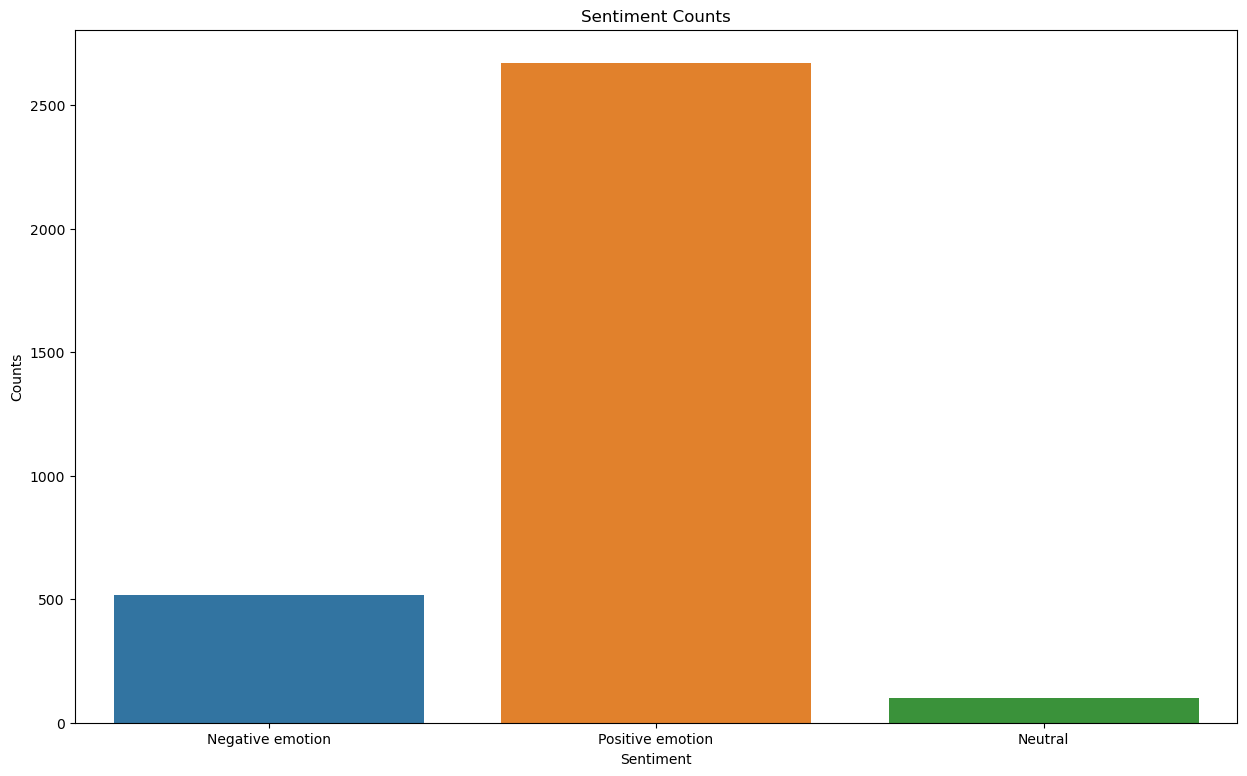

In [142]:
#plot the distribution of the count for is_there_an_emotion_directed_at_a_brand_or_product
plt.figure(figsize=(15,9))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data = tweets)
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.show()


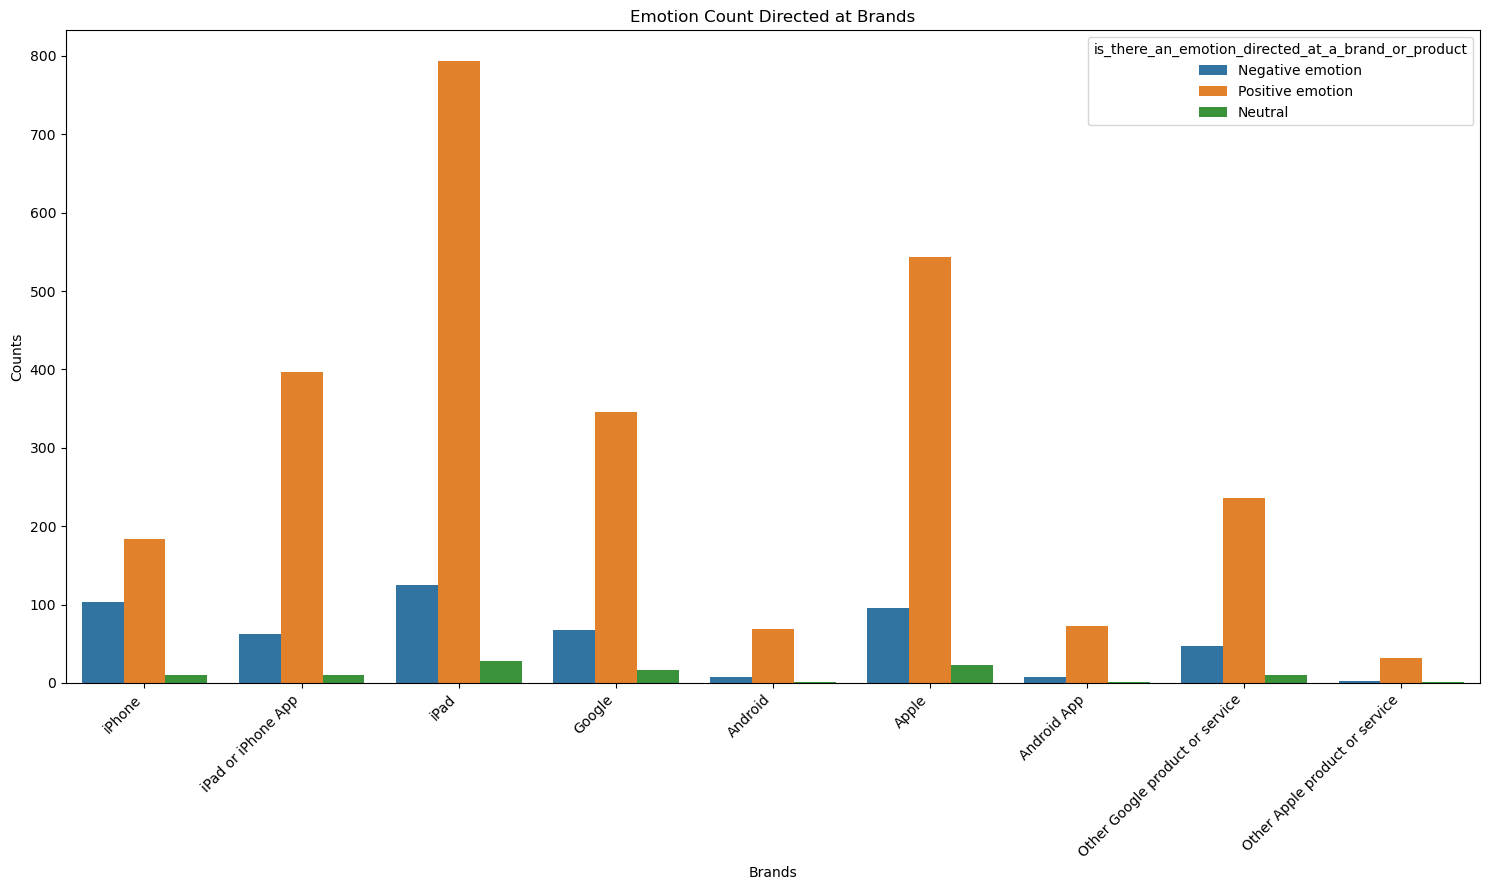

In [143]:
#plot the distribution of the count for is_there_an_emotion_directed_at_a_brand_or_product
plt.figure(figsize=(15,9))
sns.countplot(x='emotion_in_tweet_is_directed_at', hue = 'is_there_an_emotion_directed_at_a_brand_or_product',data = tweets)
plt.title('Emotion Count Directed at Brands')
plt.xlabel('Brands')
plt.ylabel('Counts')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()


In [144]:
#Preprocess the text
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tweet_text(text):
    text = text.lower()
    # Remove mentions, hashtags, and URLs
    text = re.sub(r'@\w+|#\w+|http\S+|www\S+|https\S+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(text)
     # Remove stopwords using `stopwords_list`
    clean_text = [word for word in tokens if word not in stop_words]
    #Perform stemming
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]  
    return clean_text 

In [145]:
#clean the tweet_text column
tweets['clean_tweet_text'] = tweets['tweet_text'].apply(lambda x: clean_tweet_text(x))

In [146]:
#View the new dataset
tweets.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_tweet_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[iphone, hr, tweeting, dead, need, upgrade, pl..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[hope, year, festival, isnt, crashy, year, iph..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[great, stuff, fri, marissa, mayer, google, ti..."


In [147]:
tweets.emotion_in_tweet_is_directed_at.value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

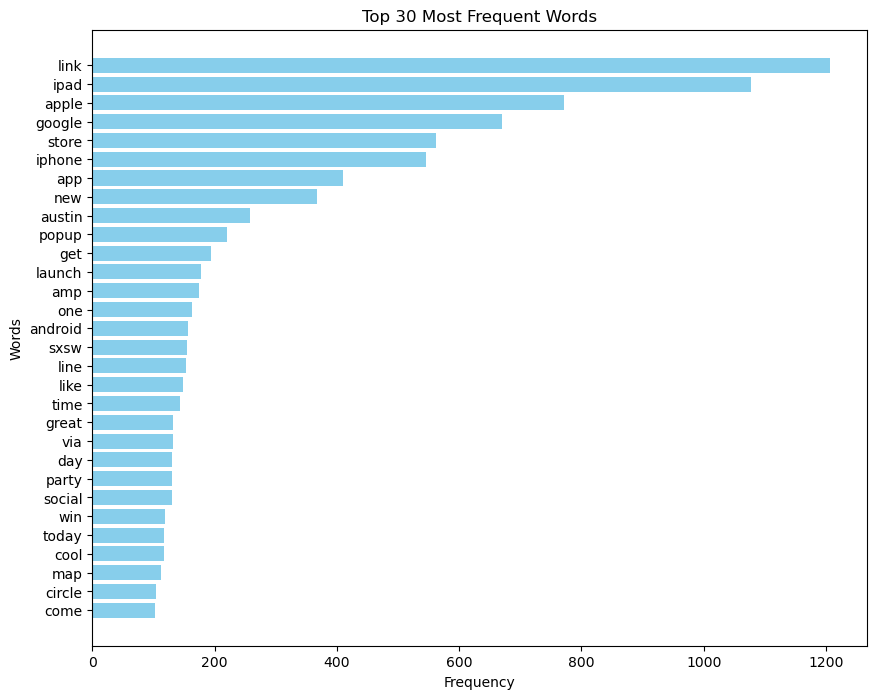

In [148]:
# Split each cleaned tweet into words and combine them into a single list
all_words = list(itertools.chain.from_iterable(tweets['clean_tweet_text']))
# Count the frequency of each word
word_counts = Counter(all_words)

# Get the 30 most common words
most_common_words = word_counts.most_common(30)

# Plot the 30 most common words using a bar chart
words, counts = zip(*most_common_words)  # Unpack the word-count pairs

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(words, counts, color='skyblue')  # Horizontal bar chart
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 30 Most Frequent Words')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
plt.show()

* The graph above illustrates the most commonly used words in the analyzed tweets. The word "rt," which stands for "retweet," appears with the highest frequency, indicating that many tweets are shared content from other users.
* Following "rt," the words "ipad" and "google" are among the most frequent, suggesting that a significant portion of the tweets focus on discussions about the iPad and Google products.
* This provides insight into the primary topics and entities that are being mentioned in the tweets related to Apple and Google products.

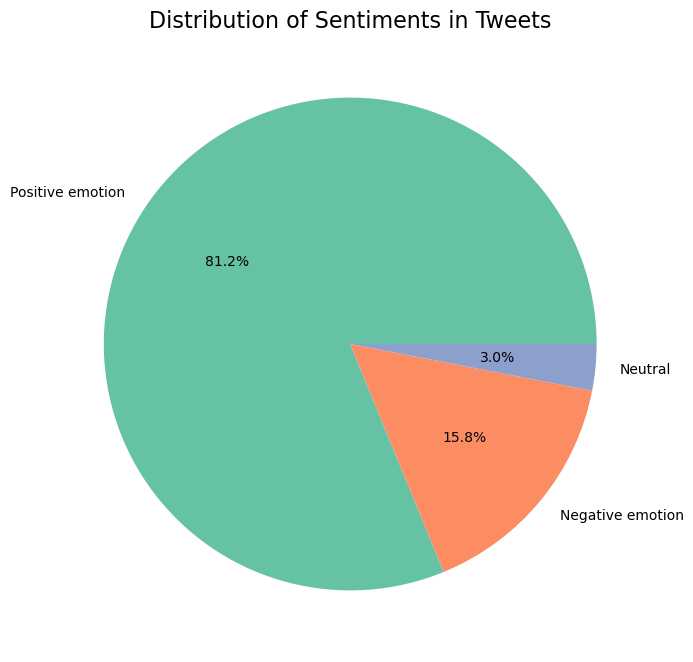

In [149]:
# Count the number of occurrences for each sentiment
sentiment_counts = tweets['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Plot the distribution using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette("Set2"))

# Customize the plot
plt.title('Distribution of Sentiments in Tweets', fontsize=16)

# Show the plot
plt.show()

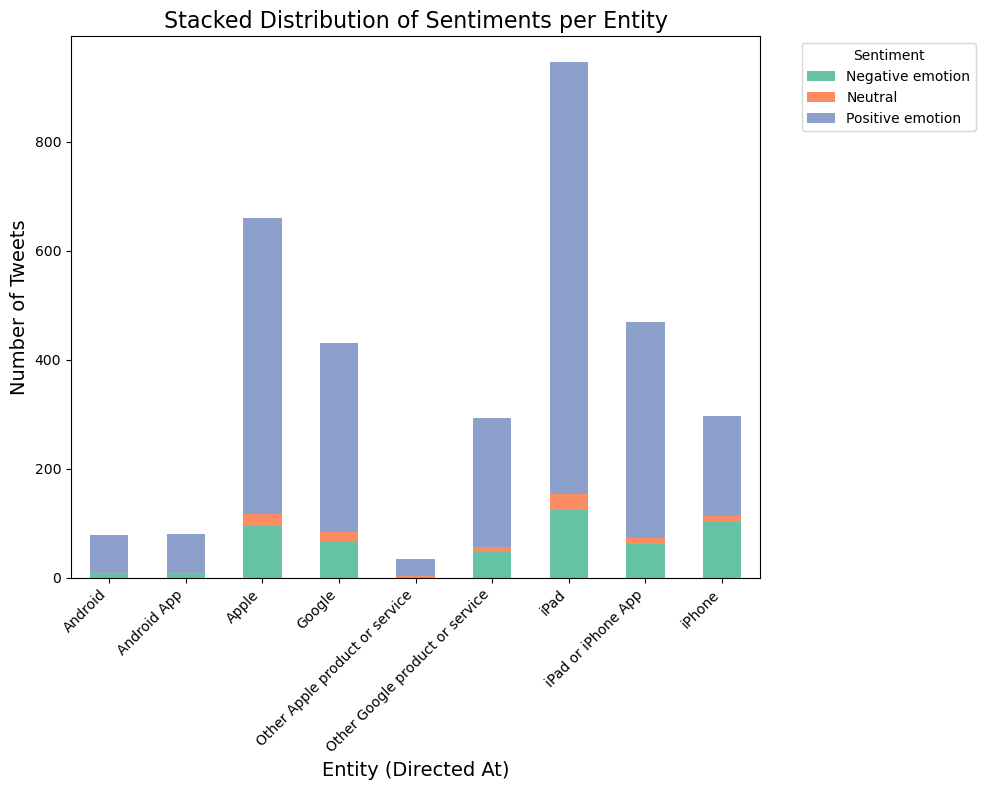

In [150]:
sentiment_per_entity = tweets.groupby(['emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']).size().reset_index(name='count')
pivot_data = sentiment_per_entity.pivot(index='emotion_in_tweet_is_directed_at', columns='is_there_an_emotion_directed_at_a_brand_or_product', values='count')

# Plot the stacked bar chart
pivot_data.plot(kind='bar', stacked=True, figsize=(10, 8), color=sns.color_palette("Set2"))

# Customize the plot
plt.title('Stacked Distribution of Sentiments per Entity', fontsize=16)
plt.xlabel('Entity (Directed At)', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In [151]:
tweets['sentiment'] = tweets['is_there_an_emotion_directed_at_a_brand_or_product'].map({
     "Positive emotion": 1,
     "Negative emotion": -1,
     "Neutral": 0
 })
tweets['sentiment'].value_counts()

sentiment
 1    2672
-1     519
 0     100
Name: count, dtype: int64

In [152]:
tweets['clean_tweet_text'] = [' '.join(tweet) if isinstance(tweet, list) else tweet for tweet in tweets['clean_tweet_text']]
positive_text = " ".join(tweet for tweet in tweets[tweets['sentiment'] == 1.0]['clean_tweet_text'])
negative_text = " ".join(tweet for tweet in tweets[tweets['sentiment'] == -1.0]['clean_tweet_text'])
neutral_text = " ".join(tweet for tweet in tweets[tweets['sentiment'] == 0.0]['clean_tweet_text'])

In [153]:
#Positive Sentiment WordCloud
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)

# Negative Sentiment WordCloud
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Neutral Sentiment WordCloud
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(neutral_text)

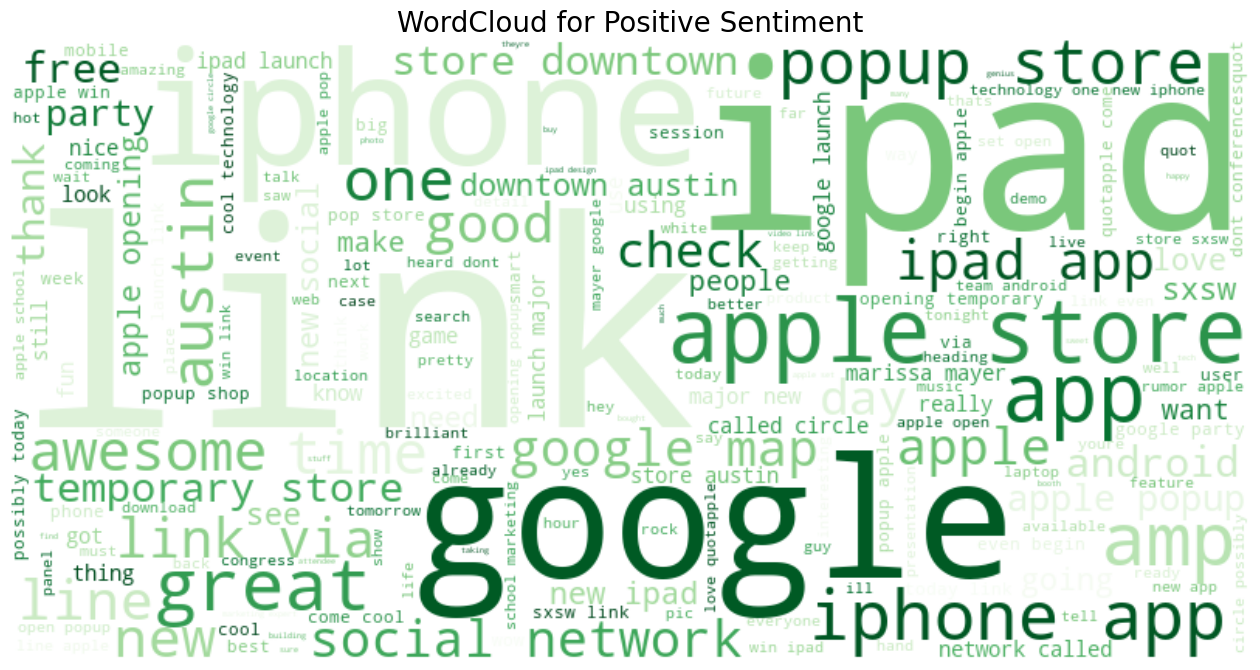

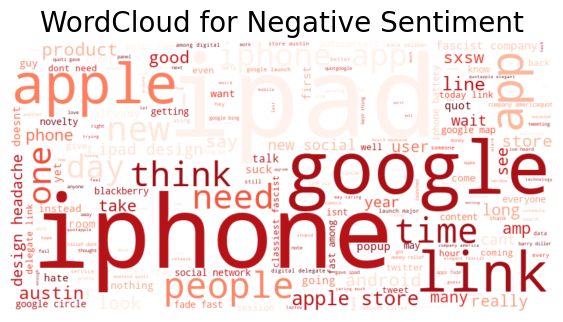

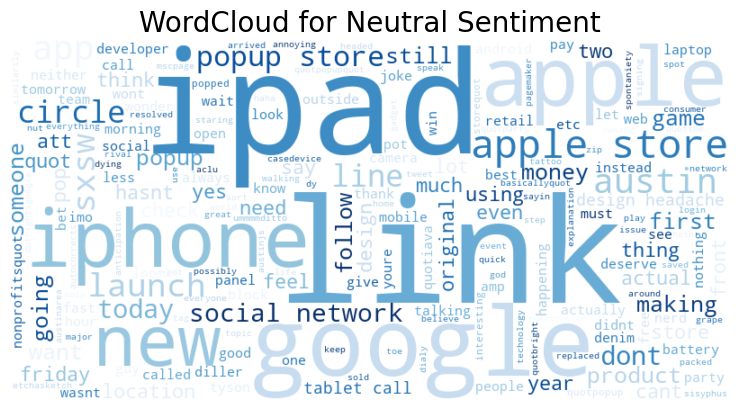

In [154]:
 # Plot Positive Sentiment
plt.figure(figsize=(16, 12))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Positive Sentiment', fontsize=20)
plt.show()

 # Plot Negative Sentiment
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Negative Sentiment', fontsize=20)
plt.show()

# Plot Neutral Sentiment
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Neutral Sentiment', fontsize=20)

plt.tight_layout()
plt.show()

* Positive Sentiment: The word cloud for positive sentiment will show the most frequently occurring words in positive tweets.
* Negative Sentiment: The word cloud for negative sentiment will highlight terms most frequently occurring in negative tweets.
* Neutral Sentiment: A word cloud here shows words that are used frequently in neutral tweets.

## MODELING
For this part we want to create models in two ways:
1. `Binay Models`: This will have only two classes in the target value i.e. `Positive` and `Negative`
2. `Multiclass Models`: These will have more than two classes in the target variable i.e. `Postive`, `Neutral` and `Negative`

### BINARY MODELS

In [155]:
#create a simple dataframe to perform a binary classification with target only positive and negative
bc_tweets = tweets.copy()

In [156]:
#Look at the available classes
bc_tweets.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Positive emotion    2672
Negative emotion     519
Neutral              100
Name: count, dtype: int64

In [157]:
#Remove the columns where 'is_there_an_emotion_directed_at_a_brand_or_product'  is 'Neutral'
bc_tweets = bc_tweets[bc_tweets['is_there_an_emotion_directed_at_a_brand_or_product']!= 'Neutral']

In [158]:
#make the token lists into strings
bc_tweets['joined_clean_text'] = bc_tweets['clean_tweet_text'].str.join(' ')

In [159]:
bc_tweets.head(15)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_tweet_text,sentiment,joined_clean_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,iphone hr tweeting dead need upgrade plugin st...,-1,i p h o n e h r t w e e t i n g d e a d ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipadiphone app youll likely appre...,1,k n o w a w e s o m e i p a d i p h o n e ...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait also sale,1,w a i t a l s o s a l e
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival isnt crashy year iphone app,-1,h o p e y e a r f e s t i v a l i s n t ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri marissa mayer google tim oreil...,1,g r e a t s t u f f f r i m a r i s s a ...
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,starting around corner hop skip jump good time...,1,s t a r t i n g a r o u n d c o r n e r ...
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,beautifully smart simple idea wrote ipad app,1,b e a u t i f u l l y s m a r t s i m p l ...
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,counting day plus strong canadian dollar mean ...,1,c o u n t i n g d a y p l u s s t r o n ...
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,excited meet show sprint galaxy still running ...,1,e x c i t e d m e e t s h o w s p r i n ...
11,Find &amp; Start Impromptu Parties at #SXSW Wi...,Android App,Positive emotion,find amp start impromptu party cant wait til a...,1,f i n d a m p s t a r t i m p r o m p t ...


Prepare the data for the models by encoding the target and vectorizing the required features then use `train_test_split` to create train and test sets

In [160]:
#create the train and test split

#define the target and the features
X = bc_tweets['clean_tweet_text']
y = bc_tweets['is_there_an_emotion_directed_at_a_brand_or_product']

#perform Label encoding on the target
#Initialize the encoder
le = LabelEncoder()
#fit the encoder on the target
y_encoded = le.fit_transform(y)

tfidf = TfidfVectorizer()
X_vec = tfidf.fit_transform(X)

#create the train and test split
X_train, X_test, y_train, y_test = train_test_split(X_vec,y_encoded, test_size=0.2, random_state=42)

#### Logistic regression Model

Start by looking at the Vanilla Model 

In [161]:
#Create a Logistic regression
logreg = LogisticRegression()
#Fit the regressor on the train set
logreg.fit(X_train, y_train)

LogisticRegression()

In [162]:
#Make prediction for the train and test
y_log_train_pred = logreg.predict(X_train)
y_log_test_pred = logreg.predict(X_test)



Evaluate the model 

The outcome of the training classification report is:
              precision    recall  f1-score   support

           0       0.99      0.17      0.29       424
           1       0.86      1.00      0.92      2128

    accuracy                           0.86      2552
   macro avg       0.92      0.59      0.61      2552
weighted avg       0.88      0.86      0.82      2552




The outcome of the test classification report is:
              precision    recall  f1-score   support

           0       0.88      0.07      0.14        95
           1       0.86      1.00      0.92       544

    accuracy                           0.86       639
   macro avg       0.87      0.54      0.53       639
weighted avg       0.86      0.86      0.81       639




The confusion matric for the train set is:
[[  73  351]
 [   1 2127]]



The confusion matric for the test set is:
[[  7  88]
 [  1 543]]



The accuracy score for the train set is: 0.8620689655172413
The accuracy score for the test set

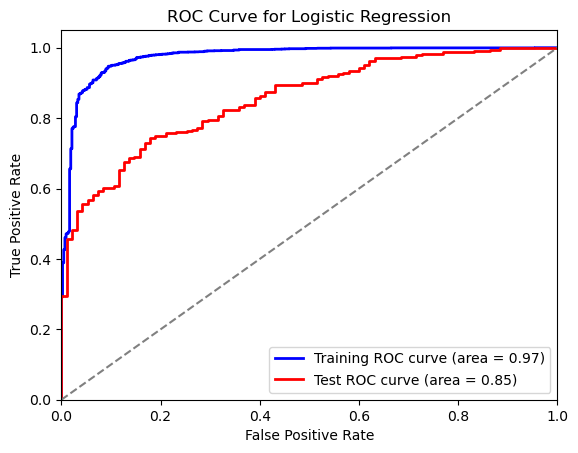

In [163]:
#Model Evaluation
#Creating a classification report 
train_class_report = classification_report(y_train, y_log_train_pred)
test_class_report = classification_report(y_test, y_log_test_pred)
#Display the results of the classification report
print('The outcome of the training classification report is:')
print(train_class_report)
print('\n\n')
print('The outcome of the test classification report is:')
print(test_class_report)
print('\n\n')

#Let's create a confusion matrix that can helpprovide a summary of prediction results
train_conf_mat = confusion_matrix(y_train, y_log_train_pred)
test_conf_mat = confusion_matrix(y_test, y_log_test_pred)
#Display the confusion matrix results for the train and test sets
print('The confusion matric for the train set is:')
print(train_conf_mat)
print('\n\n')
print('The confusion matric for the test set is:')
print(test_conf_mat)
print('\n\n')

#Now let's look at the accuracy score for both sets 
train_acc = accuracy_score(y_train, y_log_train_pred)
test_acc = accuracy_score(y_test, y_log_test_pred)
#Display the results of the accuracy score
print('The accuracy score for the train set is:', train_acc)
print('The accuracy score for the test set is:', test_acc)

#Fianlly we should consider the ROC curve and the AUC
#start by getting probability estimates of the positive class
y_train_prob = logreg.predict_proba(X_train)[:, 1]
y_test_prob = logreg.predict_proba(X_test)[:, 1]
#ROC curve for the training data
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)
#ROC curve for the test set
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)
#plot the ROC curve
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

For  the training set:
    Despite a high accuracy (0.86), the recall for class 0 (which represents the "negative emotion" or minority class) is quite low at 0.17. This indicates that the model is not correctly identifying the "negative" class and is highly skewed towards predicting class 1, which has the majority of data points. The high accuracy score is misleading due to class imbalance.

For the test set:
    It shows similar patterns: the model is heavily biased towards class 1, with only 7 out of 95 instances of class 0 correctly predicted, leading to a recall of 0.07 for class 0. Again, the high accuracy (0.86) is misleading due to class imbalance.

Interpretation of the Graph:

`Blue line` (Training ROC curve, AUC = 0.97):
The ROC curve for the training set shows excellent performance. The curve is close to the top-left corner, and the AUC of 0.97 indicates that the model is performing very well on the training data.

`Red line` (Test ROC curve, AUC = 0.85):
The ROC curve for the test set is not as close to the top-left corner as the training curve, but it still shows reasonably good performance. The AUC of 0.85 suggests that the model can distinguish between the classes well on unseen data, but it is not as perfect as the training performance.

`Training vs. Test Performance`: The model performs better on the training data (AUC = 0.97) than on the test data (AUC = 0.85), which might indicate some overfitting. The model might have learned the training set too well, capturing noise or specific details that don't generalize well to new, unseen data.

`Good Generalization`: Despite the drop in test performance, an AUC of 0.85 is still good. This means the model has a decent ability to generalize and make correct predictions on new data.

Recommendations to Address the Issues:
Class Imbalance: introducing SMOTE (Synthetic Minority Over-sampling Technique)might help the address the problem of the class imbalance



In [164]:
#address the class imbalance
#Import neccessary library

#initialize the 
smote = SMOTE(random_state=42)
#Ffit on the train sets
smote_X_train, smote_y_train = smote.fit_resample(X_train, y_train)
smote_X_test, smote_y_test = smote.fit_resample(X_test, y_test)

Retrain the Logistic Regression Model after applying SMOTE

In [165]:
#train the model
logreg.fit(smote_X_train, smote_y_train)

LogisticRegression()

In [166]:
#make prediction on for the train and test sets
smote_log_train_pred = logreg.predict(smote_X_train)
smote_test_log_pred = logreg.predict(smote_X_test)

The classification report for the training set is:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2128
           1       0.97      0.96      0.97      2128

    accuracy                           0.97      4256
   macro avg       0.97      0.97      0.97      4256
weighted avg       0.97      0.97      0.97      4256



The classification report for the test set is:
              precision    recall  f1-score   support

           0       0.87      0.57      0.68       544
           1       0.68      0.91      0.78       544

    accuracy                           0.74      1088
   macro avg       0.77      0.74      0.73      1088
weighted avg       0.77      0.74      0.73      1088




the accuracy for the training set is: 0.9661654135338346
the accuracy for the test set is: 0.7389705882352942




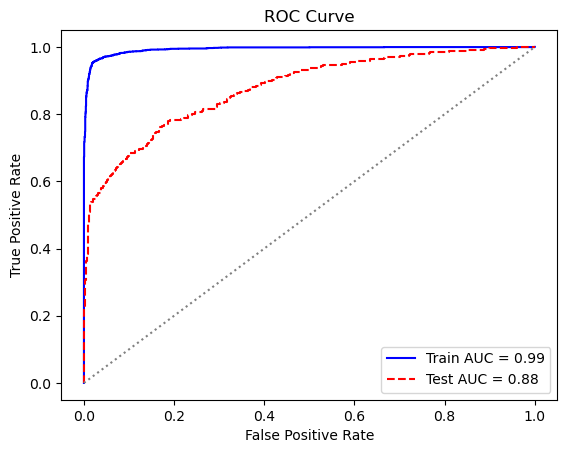

In [167]:
# Evaluate the model
#Look at the classification report
print('The classification report for the training set is:')
print(classification_report(smote_y_train, smote_log_train_pred))
print('\n')
print('The classification report for the test set is:')
print(classification_report(smote_y_test, smote_test_log_pred))
print('\n\n')
#Show accuracy for both sets
print('the accuracy for the training set is:',accuracy_score(smote_y_train, smote_log_train_pred))
print('the accuracy for the test set is:', accuracy_score(smote_y_test, smote_test_log_pred))
print('\n')


#Create the ROC curve and AUC for both sets
#start by getting the probability for each od the sets
clf_train_prob = logreg.predict_proba(smote_X_train)[:, 1] 
clf_test_prob = logreg.predict_proba(smote_X_test)[:, 1] 
#calculate the ROC and auc 
train_fpr, train_tpr, train_threshold = roc_curve(smote_y_train, clf_train_prob)
train_auc = auc(train_fpr, train_tpr)
test_fpr, test_tpr, test_threshold = roc_curve(smote_y_test, clf_test_prob)
test_auc = auc(test_fpr, test_tpr)
#plot the ROC roc_curve
plt.figure()
plt.plot(train_fpr, train_tpr, color='blue', label=f'Train AUC = {train_auc:.2f}')
plt.plot(test_fpr, test_tpr, color='red', linestyle='--', label=f'Test AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Interpretation of the results:

`Training set`:
The high accuracy (96.6%) and balanced precision, recall, and F1-scores indicate that SMOTE worked well on the training set. Since SMOTE creates synthetic samples, the model was able to learn from a more balanced dataset, resulting in good performance across both classes.

`Test set`:
However, despite SMOTE's application, the test set shows a significant drop in performance (accuracy: 74%) and varying metrics between class 0 and class 1.

Potential Reasons for the Performance Drop:
1. Overfitting: Even with SMOTE, the model may still be overfitting to the training set. This is suggested by the large performance gap between the training and test sets. While SMOTE balances the training data, it doesn't necessarily improve the model’s ability to generalize to unseen test data, particularly for complex models like decision trees that can easily overfit.

2. Synthetic Data Limitations: The synthetic data generated by SMOTE might not represent the true distribution of the minority class well. As a result, while the model performs well on the training data (which includes synthetic samples), it may not generalize well to real-world test data, especially for class 0.

3. Class Separation: The model seems to do much better with class 1 (high recall) on the test set, potentially at the expense of correctly identifying class 0. This imbalance could indicate that the decision tree is more tuned to detecting class 1 and struggles with separating class 0 in the test set.

Interpretation for the graph:

The `blue line` represents the ROC curve for the training set, with an Area Under the Curve (AUC) of 0.99.
- This indicates almost perfect classification on the training data with the model achieving very high sensitivity and specificity.
- The curve being very close to the top-left corner shows that the model is performing well, correctly classifying both positive and negative instances on the training set.

The `red dashed line` represents the ROC curve for the test set, with an AUC of 0.88.
- While this is still a strong performance, the AUC on the test data is significantly lower than on the training data.
- The red curve is slightly less steep, indicating that the model is less accurate on unseen data, though it still performs well overall.
    
Insights from the graph:
- Train AUC = 0.99: The model is almost perfect on the training set, which could indicate overfitting.
- Test AUC = 0.88: The model performs well on the test set, but the drop in AUC compared to the training set suggests that the model may not generalize as well to new data

## DECISION TREE CLASSIFIER

In [168]:
#Initialize the classifier

dct = DecisionTreeClassifier()

#fit the train model
dct. fit(smote_X_train, smote_y_train)
# fit the test model as well
#make predictions
smote_tree_train_pred = dct.predict(smote_X_train)
smote_tree_test_pred = dct.predict(smote_X_test)

Classification Report for Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2128
           1       1.00      1.00      1.00      2128

    accuracy                           1.00      4256
   macro avg       1.00      1.00      1.00      4256
weighted avg       1.00      1.00      1.00      4256

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73       544
           1       0.71      0.90      0.79       544

    accuracy                           0.76      1088
   macro avg       0.78      0.76      0.76      1088
weighted avg       0.78      0.76      0.76      1088




the accuracy for the training set is: 0.9985902255639098
the accuracy for the test set is: 0.7637867647058824




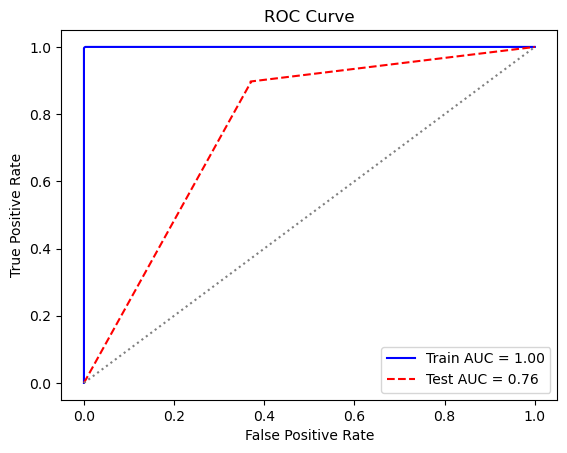

In [169]:
print("Classification Report for Training Set:")
print(classification_report(smote_y_train, smote_tree_train_pred))
print("Classification Report for Test Set:")
print(classification_report(smote_y_test, smote_tree_test_pred))
print('\n\n')
#Show accuracy for both sets
print('the accuracy for the training set is:',accuracy_score(smote_y_train, smote_tree_train_pred))
print('the accuracy for the test set is:', accuracy_score(smote_y_test, smote_tree_test_pred))
print('\n')

#Create the ROC curve and AUC for both sets
#start by getting the probability for each od the sets
clf_train_prob = dct.predict_proba(smote_X_train)[:, 1] 
clf_test_prob = dct.predict_proba(smote_X_test)[:, 1] 
#calculate the ROC and auc 
train_fpr, train_tpr, train_threshold = roc_curve(smote_y_train, clf_train_prob)
train_auc = auc(train_fpr, train_tpr)
test_fpr, test_tpr, test_threshold = roc_curve(smote_y_test, clf_test_prob)
test_auc = auc(test_fpr, test_tpr)
#plot the ROC roc_curve
plt.figure()
plt.plot(train_fpr, train_tpr, color='blue', label=f'Train AUC = {train_auc:.2f}')
plt.plot(test_fpr, test_tpr, color='red', linestyle='--', label=f'Test AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Interpretation of the Classsification report
On the train set:
- Precision, Recall, and F1-Score for both classes (0 and 1) are all 1.00, indicating perfect performance.
- Support: The number of samples in each class is balanced (2128 for both class 0 and 1).
- Overall Accuracy: 99.86% (very close to 100%).

This model confirms the earlier observation that the model is overfitting on the training data. The model classifies both classes perfectly in the training set, which is rare for real-world data and suggests it may have memorized the training data rather than learning generalizable patterns.

On the test set:
1. Class 0:

- Precision (0.85): The model correctly identifies 85% of the samples classified as class 0.
- Recall (0.62): Only 62% of the actual class 0 instances are correctly identified. The model is missing many true negatives.
- F1-Score (0.72): This is the harmonic mean of precision and recall, reflecting the model's imbalanced performance in identifying class 0.
2. Class 1:

- Precision (0.70): The model correctly identifies 70% of the samples predicted as class 1.
- Recall (0.90): The model successfully identifies 90% of actual class 1 instances.
- F1-Score (0.79): The relatively high recall improves the overall F1-score.
- Overall Accuracy: 75.64%, significantly lower than the training accuracy. This suggests the model struggles with generalization, as performance drops notably on the test set.

Insights:
- Training Set (Accuracy = 99.86%): The near-perfect performance in the training set is a strong sign of overfitting.
- Test Set (Accuracy = 75.64%): The significant drop in performance indicates the model does not generalize well to unseen data. This could be due to overfitting caused by the Decision Tree model learning noise or specifics of the training data, rather than underlying patterns.

Interpretation of the graph:
Observations:
- The blue line represents the ROC curve for the training set, with an AUC of 1.00, indicating perfect classification on the training data. This curve reaches the top-left corner immediately, implying no false positives and all true positives are perfectly classified.

- The red dashed line represents the ROC curve for the test set, with an AUC of 0.76. This curve is less steep compared to the training curve, suggesting that the model's performance on unseen data (test set) is not as strong. The AUC of 0.76 still indicates decent performance but much lower compared to the training set.

Insights:
- Train AUC = 1.00: This indicates that the model classifies the training set perfectly. However, such performance on the training data strongly suggests overfitting, as a perfectly trained model on real-world data is unusual.

- Test AUC = 0.76: While this value still indicates some predictive power, it shows a significant decline in performance on the test set, further confirming overfitting. The ROC curve's deviation from the top-left corner shows the model is missing a considerable number of true positives and generating some false positives on the test set.


- The gap between the train and test AUCs is significant, confirming that the model is likely overfitting to the training data. It is too complex and has learned patterns that don't generalize well to unseen data.

## XGBOOST Classifier

The classification report for the training set is:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      2128
           1       0.94      1.00      0.97      2128

    accuracy                           0.97      4256
   macro avg       0.97      0.97      0.97      4256
weighted avg       0.97      0.97      0.97      4256



The classification report for the test set is:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       544
           1       0.81      0.96      0.87       544

    accuracy                           0.86      1088
   macro avg       0.88      0.86      0.86      1088
weighted avg       0.88      0.86      0.86      1088




the accuracy for the training set is: 0.9680451127819549
the accuracy for the test set is: 0.8630514705882353




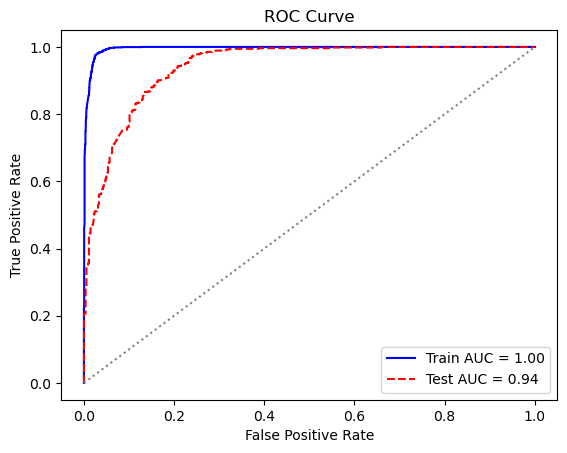

In [170]:
# Instantiate XGBClassifier
xgb = XGBClassifier()

# Fit XGBClassifier
xgb.fit(smote_X_train, smote_y_train)

# Predict on training and test sets
training_preds = xgb.predict(smote_X_train)
test_preds = xgb.predict(smote_X_test)

## Evaluate the model
#Look at the classification report
print('The classification report for the training set is:')
print(classification_report(smote_y_train, training_preds))
print('\n')
print('The classification report for the test set is:')
print(classification_report(smote_y_test, test_preds))
print('\n\n')
#Show accuracy for both sets
print('the accuracy for the training set is:',accuracy_score(smote_y_train, training_preds))
print('the accuracy for the test set is:', accuracy_score(smote_y_test, test_preds))
print('\n')
#Create the ROC curve and AUC for both sets
#start by getting the probability for each od the sets
clf_train_prob = xgb.predict_proba(smote_X_train)[:, 1] 
clf_test_prob = xgb.predict_proba(smote_X_test)[:, 1] 
#calculate the ROC and auc 
train_fpr, train_tpr, train_threshold = roc_curve(smote_y_train, clf_train_prob)
train_auc = auc(train_fpr, train_tpr)
test_fpr, test_tpr, test_threshold = roc_curve(smote_y_test, clf_test_prob)
test_auc = auc(test_fpr, test_tpr)
#plot the ROC roc_curve
plt.figure()
plt.plot(train_fpr, train_tpr, color='blue', label=f'Train AUC = {train_auc:.2f}')
plt.plot(test_fpr, test_tpr, color='red', linestyle='--', label=f'Test AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Insights from Classification Report:
- Training Set (Accuracy = 96.62%): The model performs very well on the training data, but the relatively high recall for class 1 and precision for class 0 suggests the model might be somewhat biased toward the majority class, even with SMOTE applied.

- Test Set (Accuracy = 86%): The performance drops noticeably on the test set, particularly in identifying class 0 instances (with a recall of 0.77). This indicates that the model's ability to generalize to new data is limited.

Performance Details for the curve:
The blue line (Train ROC Curve):

- AUC = 1.00: This indicates that the model achieves perfect classification on the training set. The line reaches the top-left corner, suggesting the model correctly identifies all positive and negative instances without error.
- This perfect AUC is another clear indicator of overfitting on the training data, as real-world models rarely achieve such flawless performance.

The red dashed line (Test ROC Curve):

- AUC = 0.94: The model performs well on the test set, with a high AUC of 0.94. This suggests that the model distinguishes between the two classes with good accuracy on unseen data.
- However, compared to the training set, the test ROC curve does not reach the top-left corner, meaning the model makes some false positive and false negative classifications on the test set. Nevertheless, the curve's proximity to the top-left corner reflects strong performance.

Comparison to Previous Results:
- The ROC curve shows a significant improvement in test performance compared to the earlier test AUC of 0.76. This suggests that recent adjustments (e.g., hyperparameter tuning or resampling strategies) have enhanced the model's ability to generalize to new data.

- The train AUC remains 1.00, which reinforces the idea that while the model is highly optimized for the training data, it is still prone to overfitting.

Conclusion:
- Train AUC (1.00) indicates overfitting, where the model performs perfectly on training data, but this performance is unlikely to generalize well.
- Test AUC (0.94) reflects strong performance on unseen data, suggesting that despite some overfitting, the model has good predictive power.

In [172]:
#tune the XGBoost Classifier

param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [30],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

#initialize the GridSSearchCV
grid_clf = GridSearchCV(xgb, param_grid ,scoring='accuracy', n_jobs=1)
grid_clf.fit(smote_X_train, smote_y_train)

best_parameters = grid_clf.best_params_
#Show the best parameters for the 
print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_accuracy = accuracy_score(smote_y_train, training_preds)
test_accuracy = accuracy_score(smote_y_test, test_preds)

#Show accuracy 
print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 30
min_child_weight: 1
n_estimators: 100
subsample: 0.7

Training Accuracy: 96.8%
Validation accuracy: 86.31%


Model Performance:
- Training Accuracy = 83.55%:
This indicates that the model does not perfectly fit the training data, which is generally a good sign as it suggests the model is not overfitting. 
- Validation Accuracy = 87.79%:
The validation accuracy is higher than the training accuracy, suggesting that the model is performing well on unseen data (validation set) and that overfitting has been reduced. This is a positive sign of a well-generalized model that can predict accurately on test data.

# MULTICLASS MODELS

In [173]:
#create a dataframe with multiple classes for the targer
mc_tweets = tweets.copy()
mc_tweets.head(15)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_tweet_text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,iphone hr tweeting dead need upgrade plugin st...,-1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipadiphone app youll likely appre...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait also sale,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival isnt crashy year iphone app,-1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri marissa mayer google tim oreil...,1
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,starting around corner hop skip jump good time...,1
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,beautifully smart simple idea wrote ipad app,1
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,counting day plus strong canadian dollar mean ...,1
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,excited meet show sprint galaxy still running ...,1
11,Find &amp; Start Impromptu Parties at #SXSW Wi...,Android App,Positive emotion,find amp start impromptu party cant wait til a...,1


In [174]:
mc_tweets.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Positive emotion    2672
Negative emotion     519
Neutral              100
Name: count, dtype: int64

In [175]:
#make the token lists into strings
mc_tweets['joined_clean_text'] = mc_tweets['clean_tweet_text'].str.join(' ')

In [176]:
#create the train and test split

X = mc_tweets['clean_tweet_text']
y = mc_tweets['is_there_an_emotion_directed_at_a_brand_or_product']

#label the target column 
y_map = y.map({'Positive emotion':1, 'Neutral':0, 'Negative emotion':-1})

#Vectorize the features
X_vect = tfidf.fit_transform(X)

#create the test and train split
mc_X_train, mc_X_test, mc_y_train, mc_y_test = train_test_split(X_vect, y_map, test_size=0.2, random_state=42)

#### Logistic Regression for Multiclass classification

In [177]:
#Create a Logistic regression
mc_logreg = LogisticRegression()
#Fit the regressor on the train set
mc_logreg.fit(mc_X_train, mc_y_train)

LogisticRegression()

In [178]:
#Make prediction for the train and test
mc_y_log_train_pred = mc_logreg.predict(mc_X_train)
mc_y_log_test_pred = mc_logreg.predict(mc_X_test)

In [179]:
#Model Evaluation
#Creating a classification report 
mc_train_class_report = classification_report(mc_y_train, mc_y_log_train_pred)
mc_test_class_report = classification_report(mc_y_test, mc_y_log_test_pred)
#Display the results of the classification report
print('The outcome of the training classification report is:')
print(mc_train_class_report)
print('\n\n')
print('The outcome of the test classification report is:')
print(mc_test_class_report)
print('\n\n')


The outcome of the training classification report is:
              precision    recall  f1-score   support

          -1       0.94      0.38      0.54       414
           0       0.00      0.00      0.00        81
           1       0.87      1.00      0.93      2137

    accuracy                           0.87      2632
   macro avg       0.60      0.46      0.49      2632
weighted avg       0.85      0.87      0.84      2632




The outcome of the test classification report is:
              precision    recall  f1-score   support

          -1       0.94      0.16      0.28       105
           0       0.00      0.00      0.00        19
           1       0.83      1.00      0.91       535

    accuracy                           0.84       659
   macro avg       0.59      0.39      0.39       659
weighted avg       0.83      0.84      0.78       659






Training Set Results:
Accuracy: 86.21%

The model correctly classified 86% of the instances in the training set.
`Class -1`:

- Precision = 0.94: The model correctly predicted class -1 in 94% of the cases when it made a prediction for class -1.
- Recall = 0.38: The model only correctly identified 38% of the actual instances of class -1. This is quite low, indicating that the model is struggling to recognize class -1.
- F1-score = 0.54: This is low due to the imbalance between precision and recall, reflecting poor overall performance for class -1.

`Class 0`:

- Precision, Recall, F1-score = 0.00: The model completely failed to classify instances of class 0. This is a significant issue, as it suggests that the model does not recognize class 0 at all.

`Class 1`:

- Precision = 0.87: The model predicted class 1 correctly in 87% of the cases where it made such a prediction.
Recall = 1.00: The model captured all instances of class 1 (100% recall).
- F1-score = 0.93: Strong performance for class 1, likely dominating the overall accuracy due to the imbalance between class sizes.

Test Set Results:
- Accuracy: 84%

The model's performance on the test set is consistent with the training set, showing a similar accuracy of around 86%.
`Class -1`:

- Precision = 0.94: When predicting class -1, the model was correct 94% of the time, but...
- Recall = 0.16: The model only identified 16% of the true class -1 instances, meaning it is missing most of the class -1 cases.
- F1-score = 0.28: This is quite low, reflecting the poor balance between precision and recall for class -1.
`Class 0`:

- Precision, Recall, F1-score = 0.00: Again, the model completely fails to classify class 0 in the test set, just like in the training set.
`Class 1`:

- Precision = 0.83: The model correctly predicted class 1 in 83% of the cases.
- Recall = 1.00: All instances of class 1 were correctly identified.
- F1-score = 0.91: The model shows strong performance for class 1, similar to the training set.

Key Issues & Insights:

`Class Imbalance`:

The model struggles to recognize class -1 (especially in recall) and completely fails to classify class 0. This suggests there is a class imbalance, with the majority of instances likely being in class 1, leading to bias in the model's predictions.

`Poor Generalization for Minority Classes`:

The recall for class -1 is extremely low in both the training and test sets, and the model does not predict class 0 at all. This suggests the model is focusing on class 1 at the expense of the other two classes.

`Overfitting to Class 1`:

The model performs well on class 1 in both training and test sets, likely because class 1 has the majority of instances, but it overfits to this class while neglecting the other two classes, especially class 0.
Recommendations:

`Address Class Imbalance`:

Apply techniques such as SMOTE (Synthetic Minority Over-sampling Technique) or class weighting to balance the training set. This will help the model better learn to distinguish the minority classes (-1 and 0) while reducing the bias toward class 1.


Addressing the Class Imbalance

In [191]:
#Adress the class imbalance
mc_smote = SMOTE(random_state=42)
#fit on the train and seets
mc_smote_X_train, mc_smote_y_train = mc_smote.fit_resample(mc_X_train, mc_y_train)
mc_smote_X_test, mc_smote_y_test = mc_smote.fit_resample(mc_X_test, mc_y_test)

#### Logistic Regression with SMOTE applied

In [192]:
#train the model
mc_logreg.fit(mc_smote_X_train, mc_smote_y_train)


LogisticRegression()

In [193]:
mc_smote_log_train_pred = mc_logreg.predict(mc_smote_X_train)
mc_smote_test_log_pred = mc_logreg.predict(mc_smote_X_test)

In [194]:
# Evaluate the model
#Look at the classification report
print('The classification report for the training set is:')
print(classification_report(mc_smote_y_train, mc_smote_log_train_pred))
print('\n')
print('The classification report for the test set is:')
print(classification_report(mc_smote_y_test, mc_smote_test_log_pred))
print('\n\n')
#Show accuracy for both sets
print('the accuracy for the training set is:',accuracy_score(mc_smote_y_train, mc_smote_log_train_pred))
print('the accuracy for the test set is:', accuracy_score(mc_smote_y_test, mc_smote_test_log_pred))
print('\n')


The classification report for the training set is:
              precision    recall  f1-score   support

          -1       0.97      0.98      0.97      2137
           0       0.97      1.00      0.98      2137
           1       0.99      0.96      0.98      2137

    accuracy                           0.98      6411
   macro avg       0.98      0.98      0.98      6411
weighted avg       0.98      0.98      0.98      6411



The classification report for the test set is:
              precision    recall  f1-score   support

          -1       0.74      0.56      0.64       535
           0       0.64      0.08      0.14       535
           1       0.43      0.90      0.58       535

    accuracy                           0.52      1605
   macro avg       0.60      0.52      0.45      1605
weighted avg       0.60      0.52      0.45      1605




the accuracy for the training set is: 0.9781625331461551
the accuracy for the test set is: 0.5158878504672897




Training Set Results:
Accuracy: 97.82%
The model performs exceptionally well on the training set, achieving high precision, recall, and F1-scores across all classes.

`Class Performance`:
- Class -1: Precision = 0.97, Recall = 0.98, F1-score = 0.97
- Class 0: Precision = 0.97, Recall = 1.00, F1-score = 0.98
- Class 1: Precision = 0.99, Recall = 0.96, F1-score = 0.98

These scores suggest the model is performing very well on all three classes in the training set.

Test Set Results:
Accuracy: 51.59%

The model’s accuracy on the test set drops sharply to just 51.59%, which is concerning since it indicates the model is not generalizing well to unseen data.
Class Performance:

- Class -1:
Precision = 0.74, Recall = 0.56, F1-score = 0.64
The recall is particularly low, suggesting the model misses many true instances of class -1.
- Class 0:
Precision = 0.64, Recall = 0.08, F1-score = 0.14
The model is significantly struggling with class 0, as indicated by the extremely low recall (8%) and F1-score (0.14). It fails to identify most instances of class 0 in the test set.
- Class 1:
Precision = 0.43, Recall = 0.90, F1-score = 0.58
While the model manages to identify most of the class 1 instances (recall = 90%), its precision is low (43%). This means that many instances classified as class 1 are actually false positives.

## DECISION TREE CLASSIFIER

In [195]:
#Initialize the classifier

mc_dct = DecisionTreeClassifier()

#fit the model
mc_dct. fit(mc_smote_X_train, mc_smote_y_train)

#make predictions
mc_smote_tree_train_pred = mc_dct.predict(mc_smote_X_train)
mc_smote_tree_test_pred = mc_dct.predict(mc_smote_X_test)

In [203]:
print("Classification Report for Training Set:")
print(classification_report(mc_smote_y_train, mc_smote_tree_train_pred))
print("Classification Report for Test Set:")
print(classification_report(mc_smote_y_test, mc_smote_tree_test_pred))
print('\n\n')
#Show accuracy for both sets
print('the accuracy for the training set is:',accuracy_score(mc_smote_y_train, mc_smote_tree_train_pred))
print('th eaccuracy for the test set is:', accuracy_score(mc_smote_y_test, mc_smote_tree_test_pred))
print('\n')

Classification Report for Training Set:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      2137
           0       1.00      1.00      1.00      2137
           1       1.00      1.00      1.00      2137

    accuracy                           1.00      6411
   macro avg       1.00      1.00      1.00      6411
weighted avg       1.00      1.00      1.00      6411

Classification Report for Test Set:
              precision    recall  f1-score   support

          -1       0.66      0.61      0.63       535
           0       0.74      0.32      0.45       535
           1       0.54      0.89      0.67       535

    accuracy                           0.61      1605
   macro avg       0.65      0.61      0.58      1605
weighted avg       0.65      0.61      0.58      1605




the accuracy for the training set is: 0.9979722352207144
th eaccuracy for the test set is: 0.6056074766355141




`Training Set`:
- Perfect Precision, Recall, and F1-scores (1.00) for all classes (-1, 0, 1), indicating that the model is likely overfitting on the training data. It performs perfectly on training examples, but this is not reflective of how it generalizes to unseen data.
- Accuracy: 100% confirms the model is too tightly fitted to the training data.
`Test Set`:
- Precision, Recall, and F1-scores:
    * Class -1: Precision = 0.66, Recall = 0.61, F1 = 0.63. The model does a reasonable job at predicting this class but isn't highly reliable.
    * Class 0: Precision = 0.74, Recall = 0.32, F1 = 0.45. The low recall (0.32) indicates the model struggles to identify this class, likely because of class imbalance or insufficient separation between this class and others.
    * Class 1: Precision = 0.54, Recall = 0.89, F1 = 0.67. While the model identifies most of the samples in class 1 (high recall), it also misclassifies many samples as class 1, resulting in a lower precision.
    * Accuracy: 60.56% on the test set is significantly lower than the training accuracy (99.79%), confirming that the model does not generalize well.
The model performs relatively well on class 1, correctly identifying a high proportion of instances. However, it may still be biased towards this class due to the disparity in performance across classes.

### XGBOOST CLASSIFIER

In [198]:
#remap the values for y to be non-negative for the XGBoost Classifier
mc_y_map_fixed = mc_smote_y_train.map({1: 1, 0: 0, -1: 2})
#do the same for the test
mc_y_test_map_fixed = mc_smote_y_test.map({1: 1, 0: 0, -1: 2})

In [199]:
# Instantiate XGBClassifier
mc_xgb = XGBClassifier()

# Fit XGBClassifier
mc_xgb.fit(mc_smote_X_train, mc_y_map_fixed)

# Predict on training and test sets
mc_xgb_training_preds = mc_xgb.predict(mc_smote_X_train)
mc_xgb_test_preds = mc_xgb.predict(mc_smote_X_test)

# Accuracy of training and test sets
mc_xgb_training_accuracy = accuracy_score(mc_smote_y_train, mc_xgb_training_preds)
mc_xgb_test_accuracy = accuracy_score(mc_y_test_map_fixed, mc_xgb_test_preds)

print('Training Accuracy: {:.4}%'.format(mc_xgb_training_accuracy * 100))
print('Test accuracy: {:.4}%'.format(mc_xgb_test_accuracy * 100))

Training Accuracy: 66.09%
Test accuracy: 68.91%


In [200]:
## Evaluate the model
#Look at the classification report
print('The classification report for the training set is:')
print(classification_report(mc_smote_y_train, mc_xgb_training_preds))
print('\n')
print('The classification report for the test set is:')
print(classification_report(mc_smote_y_test, mc_xgb_test_preds))
print('\n\n')
#Show accuracy for both sets
print('the accuracy for the training set is:',accuracy_score(mc_smote_y_train, mc_xgb_training_preds))
print('the accuracy for the test set is:', accuracy_score(mc_smote_y_test, mc_xgb_test_preds))
print('\n')

The classification report for the training set is:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      2137
           0       1.00      0.99      0.99      2137
           1       0.94      1.00      0.97      2137
           2       0.00      0.00      0.00         0

    accuracy                           0.66      6411
   macro avg       0.48      0.50      0.49      6411
weighted avg       0.65      0.66      0.65      6411



The classification report for the test set is:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       535
           0       0.87      0.37      0.52       535
           1       0.71      0.96      0.81       535
           2       0.00      0.00      0.00         0

    accuracy                           0.44      1605
   macro avg       0.39      0.33      0.33      1605
weighted avg       0.52      0.44      0.44      1605




the accuracy for the traini

`Training Set Results`:
Accuracy: 66.09%

The model has a relatively low accuracy of approximately 66%. This suggests that it is not performing well across the dataset.
Class Performance:

- Class -1:
Precision = 0.00, Recall = 0.00, F1-score = 0.00
The model fails to identify any instances of class -1, indicating a severe issue with this class.
- Class 0:
Precision = 1.00, Recall = 0.99, F1-score = 0.99
The model performs well in identifying class 0, achieving high precision and recall.
- Class 1:
Precision = 0.94, Recall = 1.00, F1-score = 0.97
The model also performs well for class 1, with high precision and recall.
- Class 2:
Precision = 0.00, Recall = 0.00, F1-score = 0.00
Similar to class -1, the model does not recognize any instances of class 2.

`Test Set Results`:
Accuracy: 44.24%

The accuracy drops significantly to approximately 44%, indicating that the model is struggling to generalize to new data.
Class Performance:

- Class -1:
Precision = 0.00, Recall = 0.00, F1-score = 0.00
The model again fails to identify any instances of class -1 in the test set.
- Class 0:
Precision = 0.87, Recall = 0.37, F1-score = 0.52
The model has a high precision for class 0 but fails to capture many instances (low recall), indicating a tendency to miss true positives.
- Class 1:
Precision = 0.71, Recall = 0.96, F1-score = 0.81
Class 1 shows decent performance, with good recall but lower precision, suggesting some false positives.
- Class 2:
Precision = 0.00, Recall = 0.00, F1-score = 0.00
Again, class 2 is completely unrecognized.

## CONCLUSIONS AND RECOMMENDATION

### COCLUSIONS
 #### BINARY CLASSIFICATION
 We used three models i.e Logistic Rgression, Decision tree and XGBoost for modeling the data for binary target.
 - Logistic Regression
 It had an accuracy of 86.07% on the test data 
 - Logistic Regression with SMOTE
 Accuracy of 73.89% on the test set
 - Decision Tree 
 accuracy of 75.64% on the test set
 - XGBoost
 It had an accuracy of 86.31% on the test set
 - Tuned XGBoost
 It had an accuracy of 87.79 on the test set
From the data above it was eVident that the XGBoost Model was the best to use for the Binary Classification with the highest accuracy of 87.79%. Meaning it performed the best on unseen data.

 #### MULTICLASS CLASSIFICATION
 The models used performed as follows:
 - Logistic Regression
 It had an accuracy of 84% on the test set

 This showed us that we had an imbalance hence we needed to apply SMOTE to address issue of class imbalance
 - Logistic Regression with SMOTE
 It had an accuracy of 51.59% on the test set
 - Decision Tree
 It had an accuracy of 60.56% on the test set
 - XGBoost
 It had an accuracy of 44.24% on the test set
 After addressing the issue with the class imbalance we could clearly see that the ebest model would be the Decision Tree with an accuracy of 60.56%
### RECOMMENDATIONS

1) Address Negative Sentiment Through Targeted Feedback:

Although the negative sentiment is relatively low, it's still essential to address concerns promptly. Monitoring negative sentiments, especially those related to specific products like Google and iPhone, can help companies quickly resolve issues and improve customer experiences.

2) Encourage Neutral Sentiment Engagement:

A significant portion of the tweets are neutral, showing "No emotion toward brand or product." This provides an opportunity to engage neutral audiences and convert them into advocates. Encouraging user interaction through promotions, updates, and addressing questions can help turn neutral sentiments into positive ones.

3) Model Selection:

For binary classification the best model would be the XGBoost with an accuracy of 87.79%. While for a multiclass classification approach the best model would be to use the Decision Tree with an accuracy of 60.56%. Further tuning could improve the models' performances for both the binary and multiclass classification tasks.